In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython import display
import glob
import pickle
import ipywidgets
import math
import json
%matplotlib inline

In [5]:
class Camera:
    def __init__(self):
        self.calibrated = False
    
    def calibrate(self, calibration_images, show_annoted = False, show_corrected = False):
        w=9
        h=6
        pattern_size = (w,h)
        pattern_square_meters = 0.02349


        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        single_object_points = np.zeros((w*h,3), np.float32)
        single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2) * pattern_square_meters

        all_object_points = []
        all_image_points = []
        im_shape = None

        for image_path in calibration_images:
            im = plt.imread(image_path)
            im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
            im_gray = (im_gray*(np.max(im_gray)-np.min(im_gray))*255 ).astype('uint8')
            if im_shape == None:
                im_shape = im_gray.shape[::-1]
            if im_gray.shape[::-1] != im_shape:
                raise( ValueError('image different shape: '+image_path))
            found,corners = cv2.findChessboardCorners(im_gray,(9,6),None)
            if found==False: 
                continue
            corners2 = cv2.cornerSubPix(im_gray,corners,(11,11),(-1,-1),criteria)
            all_image_points.append(corners2)
            all_object_points.append(single_object_points)
            if show_annoted:
                plt.figure()
                im_annoted = cv2.drawChessboardCorners(im, pattern_size, corners2, found)
                plt.imshow(im_annoted)
        cx=im_shape[1]/2.
        cy=im_shape[0]/2.
        # set initial guess for camera matrix
        camera_matrix = np.array([ [1,0,cx], [0,1,cy], [0,0,1]])
        
        ret, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(
            all_object_points, 
            all_image_points, 
            im_shape, 
            camera_matrix,
            None,
            flags = cv2.CALIB_FIX_ASPECT_RATIO)
        
        self.dist_coefs = dist_coefs
        self.camera_matrix = camera_matrix
        self.calibrated = True
        if show_corrected:
            for image_path in calibration_images:
                im = plt.imread(image_path)   
                plt.figure()
                plt.imshow(cv2.undistort(im,mtx,dst))
    
    def stereo_calibrate(self, left_image_paths, right_image_paths):
        if len(left_image_paths) != len(right_image_paths):
            raise ValueError('left and right images lists must be the same length')
        w=9
        h=6
        pattern_size = (w,h)
        pattern_square_meters = 0.02349


        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        single_object_points = np.zeros((w*h,3), np.float32)
        single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2) * pattern_square_meters

        all_object_points = []
        left_images_points = []
        right_images_points = []
        im_shape = None

        for i in range(len(left_image_paths)):
            left_image = plt.imread(left_image_paths[i])
            left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
            left_image_gray = (left_image_gray*(np.max(left_image_gray)-np.min(left_image_gray))*255 ).astype('uint8')
            
            right_image = plt.imread(right_image_paths[i])
            right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)
            right_image_gray = (right_image_gray*(np.max(right_image_gray)-np.min(right_image_gray))*255 ).astype('uint8')
            
            if im_shape == None:
                im_shape = left_image_gray.shape[::-1]
            if left_image_gray.shape[::-1] != im_shape:
                raise( ValueError('image different shape: '+image_path))
            if right_image_gray.shape[::-1] != im_shape:
                raise( ValueError('image different shape: '+image_path))
            found,left_corners = cv2.findChessboardCorners(left_image_gray,(9,6),None)
            if found==False: 
                continue
            found,right_corners = cv2.findChessboardCorners(right_image_gray,(9,6),None)
            if found==False: 
                continue
                
            
            left_images_points.append(cv2.cornerSubPix(left_image_gray,left_corners,(11,11),(-1,-1),criteria))
            right_images_points.append(cv2.cornerSubPix(right_image_gray,right_corners,(11,11),(-1,-1),criteria))
            all_object_points.append(single_object_points)
        cx=im_shape[1]/2.
        cy=im_shape[0]/2.
        # set initial guess for camera matrix
        left_camera_matrix = np.array([ [1,0,cx], [0,1,cy], [0,0,1]])
        right_camera_matrix = np.array([ [1,0,cx], [0,1,cy], [0,0,1]])
        
        ret, left_camera_matrix, left_dist_coefs, rvecs, tvecs = cv2.calibrateCamera(
            all_object_points, 
            left_images_points, 
            im_shape, 
            left_camera_matrix,
            None,
            flags = cv2.CALIB_FIX_ASPECT_RATIO)

        ret, right_camera_matrix, right_dist_coefs, rvecs, tvecs = cv2.calibrateCamera(
            all_object_points, 
            right_images_points, 
            im_shape, 
            right_camera_matrix,
            None,
            flags = cv2.CALIB_FIX_ASPECT_RATIO)

        self.left_dist_coefs = left_dist_coefs
        self.left_camera_matrix = left_camera_matrix
        self.right_dist_coefs = right_dist_coefs
        self.right__camera_matrix = right_camera_matrix
        self.stereo_calibrated = True
        
        retval, left_camera_matrix, left_dist_coefs, right_camera_matrix, right_dist_coefs, R, T, E, F  = cv2.stereoCalibrate(all_object_points, left_images_points, right_images_points, left_camera_matrix, left_dist_coefs, right_camera_matrix, right_dist_coefs, im_shape)
        R1, R2, P1, P2, Q, valid_pix_roi_1, valid_pix_roi_2 = cv2.stereoRectify(left_camera_matrix, left_dist_coefs, right_camera_matrix, right_dist_coefs, im_shape, R, T)
        
        new_left_camera_matrix, left_roi = cv2.getOptimalNewCameraMatrix(left_camera_matrix, left_dist_coefs,im_shape, 0, im_shape)
        new_right_camera_matrix, left_roi = cv2.getOptimalNewCameraMatrix(right_camera_matrix, right_dist_coefs, im_shape, 0, im_shape)
        
        left_map_x, left_map_y = cv2.initUndistortRectifyMap(left_camera_matrix, left_dist_coefs, R1, new_left_camera_matrix, im_shape, 5)
        right_map_x, right_map_y = cv2.initUndistortRectifyMap(right_camera_matrix, right_dist_coefs, R2, new_right_camera_matrix, im_shape, 5)
        

        for i in range(len(left_image_paths)):
            left_image = plt.imread(left_image_paths[i])
            right_image = plt.imread(right_image_paths[i])
            
            left_image_fixed = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
            right_image_fixed = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)
            
            stereo = cv2.StereoBM_create(numDisparities=64, blockSize=25)
            #stereo = cv2.StereoSGBM_create(minDisparity = 0,numDisparities=16, blockSize=7, P1=75, P2=150)
            
            left_gray = cv2.cvtColor(left_image_fixed, cv2.COLOR_RGB2GRAY)
            left_gray = (left_gray*(np.max(left_gray)-np.min(left_gray))*255 ).astype('uint8')
            
            right_gray = cv2.cvtColor(right_image_fixed, cv2.COLOR_RGB2GRAY)
            right_gray = (right_gray*(np.max(right_gray)-np.min(right_gray))*255 ).astype('uint8')
            
            disparity = stereo.compute(left_gray, right_gray)
            fig = plt.figure()
            fig.set_size_inches(w=16,h=8)
            plt.subplot(1,3,1)
            plt.imshow(left_gray,cmap='gray')
            plt.subplot(1,3,2)
            plt.imshow(right_gray,cmap='gray')
            plt.subplot(1,3,3)
            plt.imshow(disparity,cmap='gray')

       
    
        return left_dist_coefs, left_camera_matrix, right_dist_coefs, right_camera_matrix, R, T, E, F
            
    
    def undistort(self, im):
        if not self.calibrated:
            raise(ValueError('camera must first be calibrated'))
        return cv2.undistort(im,self.camera_matrix,self.dist_coefs)
    

processing elp1 640_480
R: [[ 0.99985168 -0.00420594 -0.01670096]
 [ 0.00452205  0.99981048  0.01893567]
 [ 0.01661815 -0.01900839  0.99968121]]
T: [[ 0.06275185]
 [-0.01407969]
 [ 0.15226841]]
E: [[-0.00092254 -0.15197192 -0.01695851]
 [ 0.151203    0.00055238 -0.06527488]
 [ 0.01436137  0.06268074  0.0009531 ]]
F: [[  2.47737894e-07   4.08101696e-05  -7.56831854e-03]
 [ -4.06036874e-05  -1.48334787e-07   2.41613800e-02]
 [  6.85404478e-03  -2.79029564e-02   1.00000000e+00]]
angle: [-1.08713615]
processing elp2 640_480
R: [[ 0.99994913  0.00305208  0.00961313]
 [-0.00297366  0.99996227 -0.00816211]
 [-0.00963768  0.00813311  0.99992048]]
T: [[ 0.06207656]
 [-0.00015545]
 [-0.00166711]]
E: [[ -3.45925479e-06   1.66578559e-03  -1.69043442e-04]
 [ -1.06875388e-03  -5.09963805e-04  -6.20876545e-02]
 [ -2.91535862e-05   6.20746968e-02  -5.05181592e-04]]
F: [[  1.84432233e-08  -8.88123523e-06   2.96152064e-03]
 [  5.69812507e-06   2.71890245e-06   1.97068114e-01]
 [ -1.45149126e-03  -1.9657

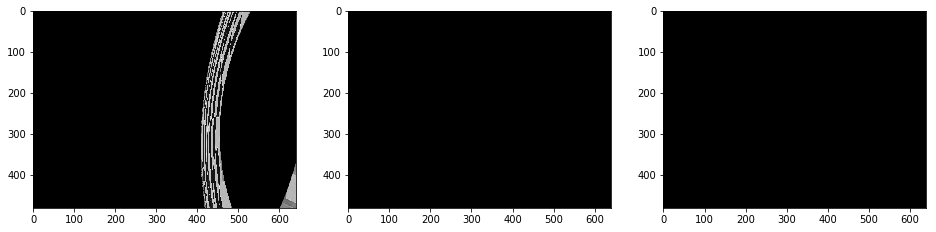

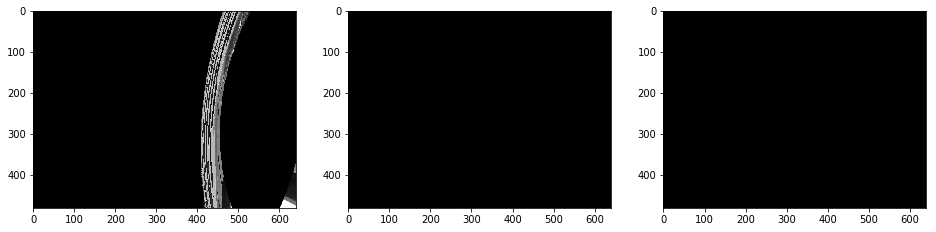

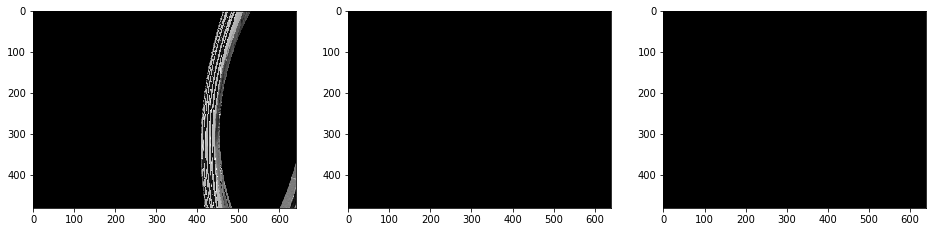

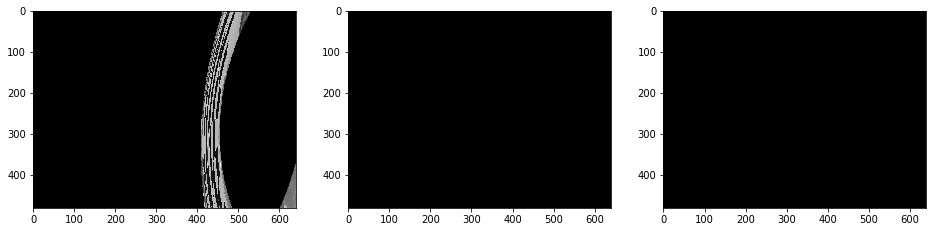

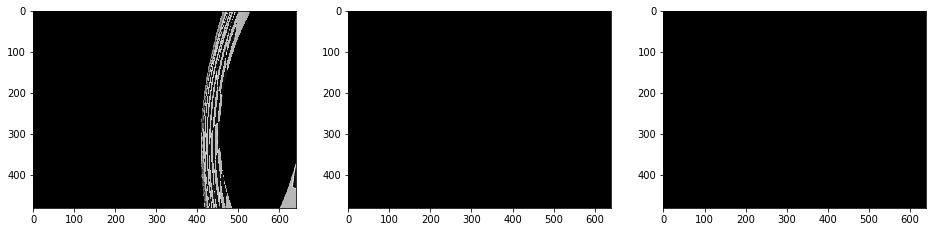

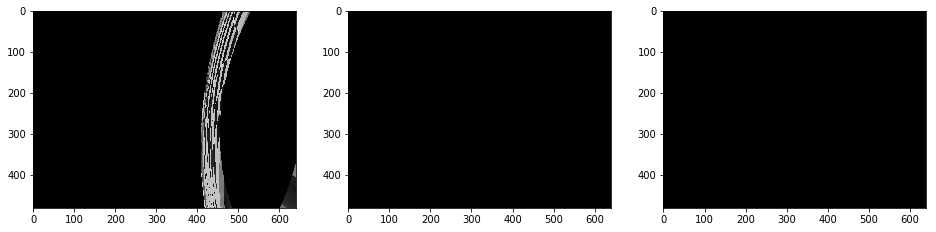

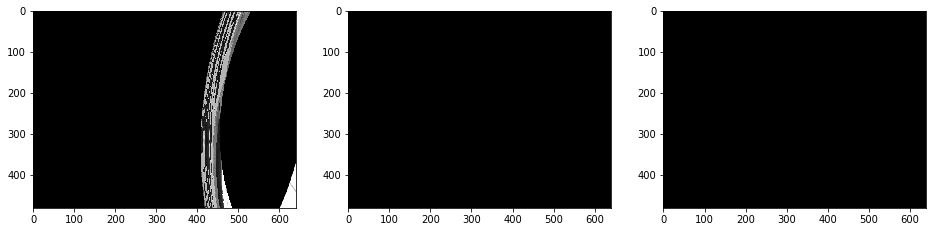

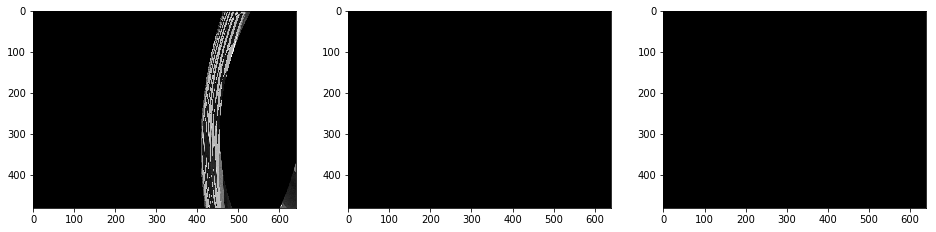

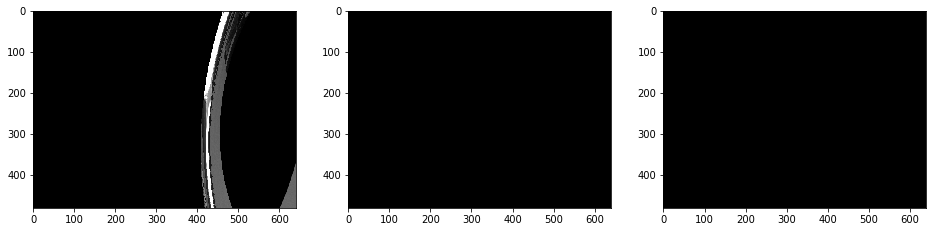

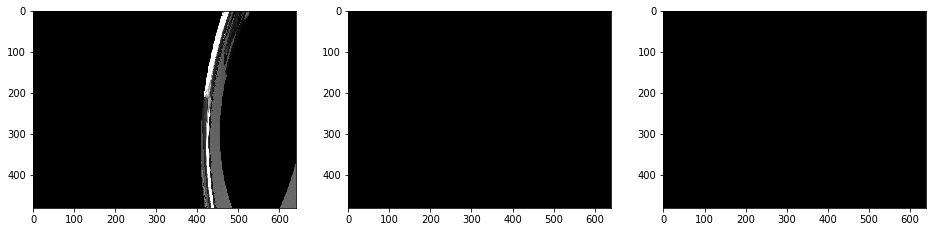

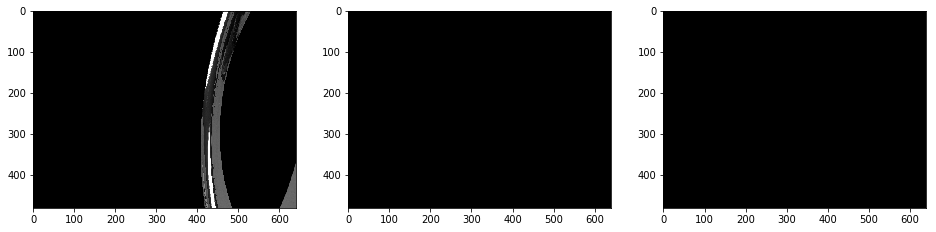

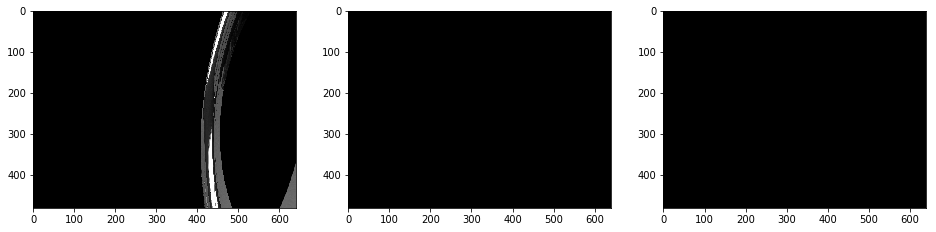

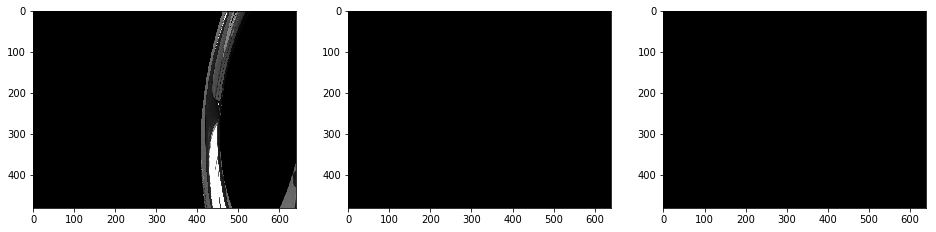

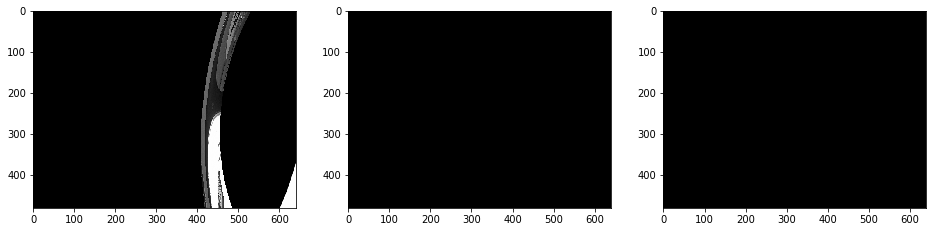

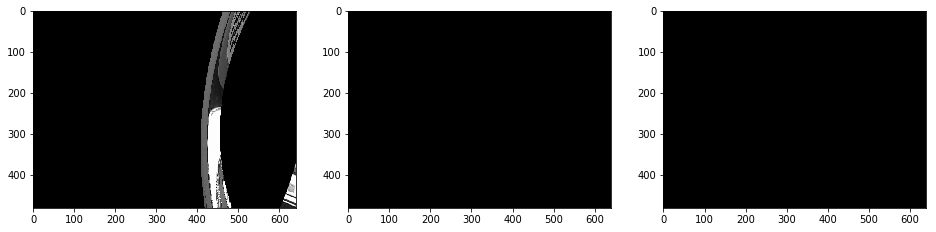

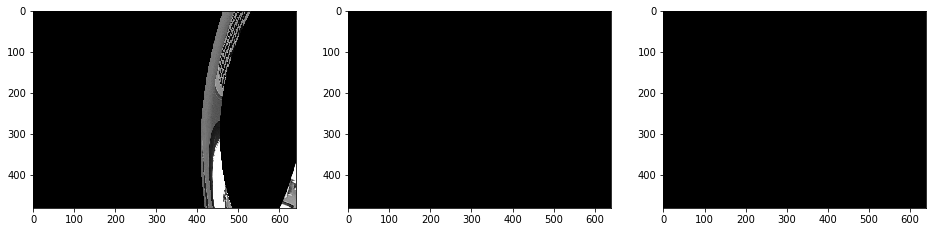

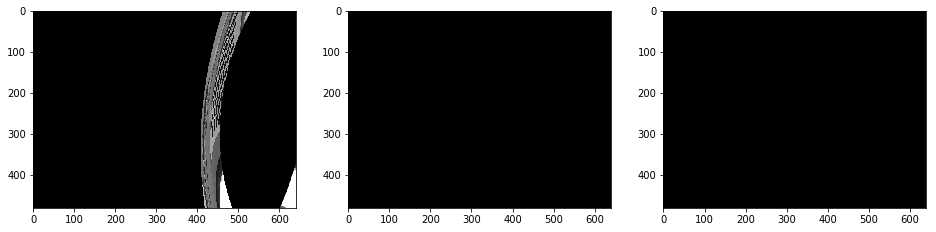

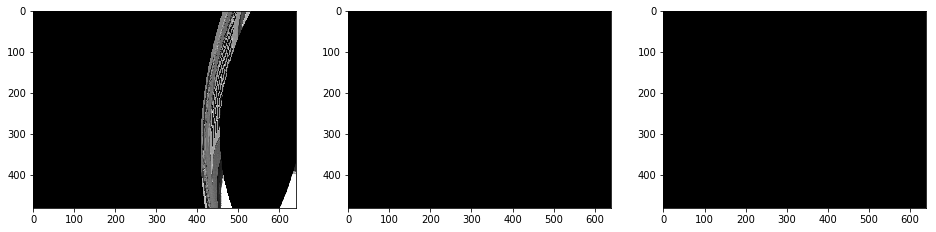

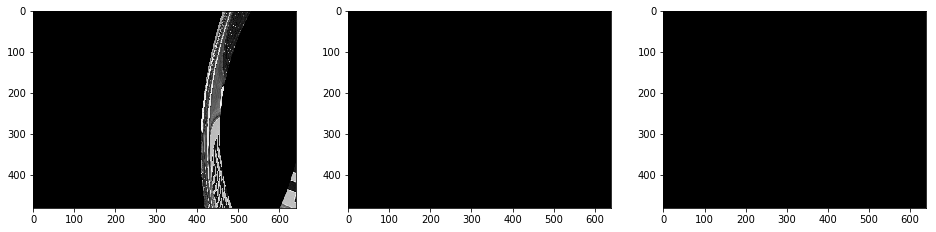

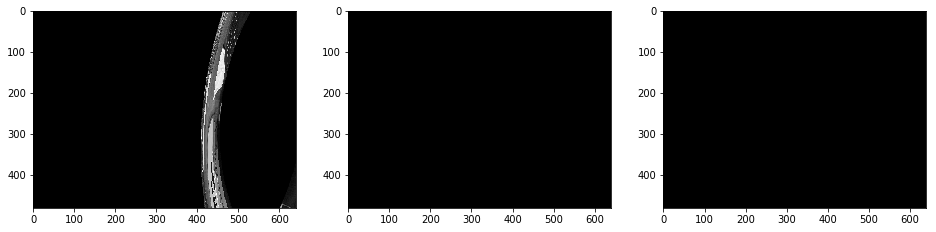

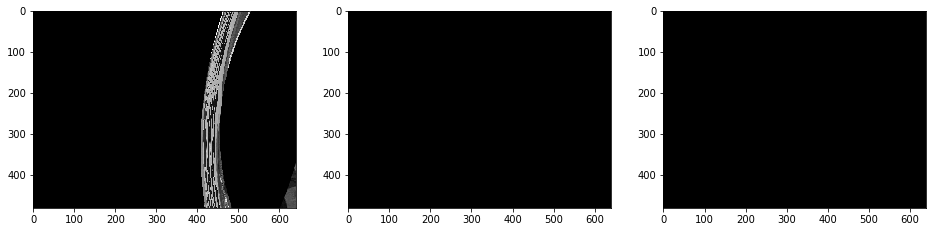

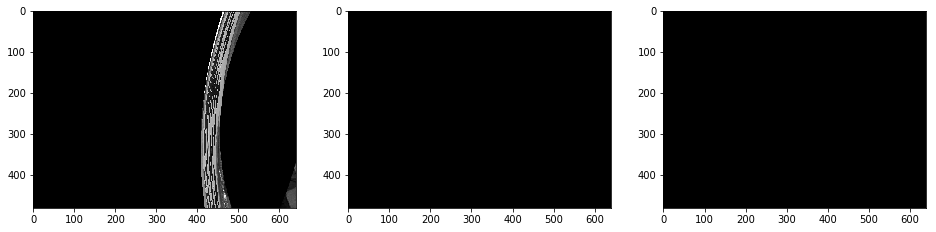

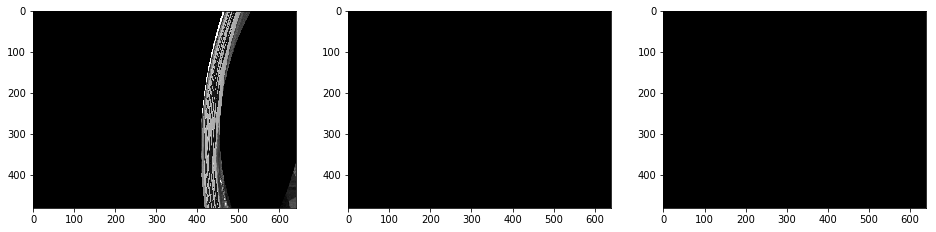

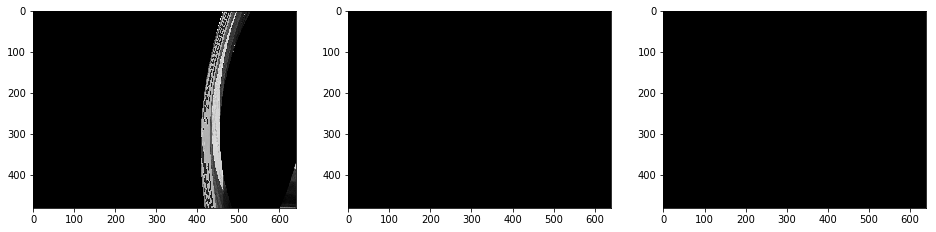

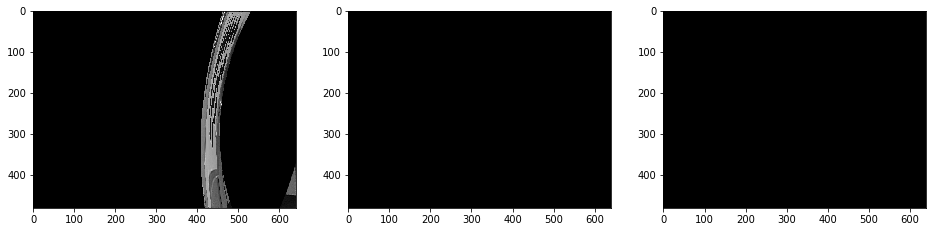

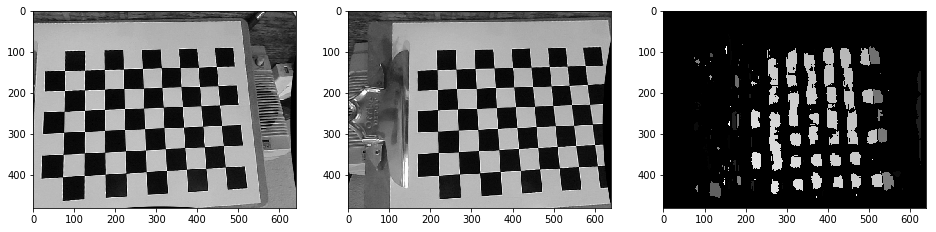

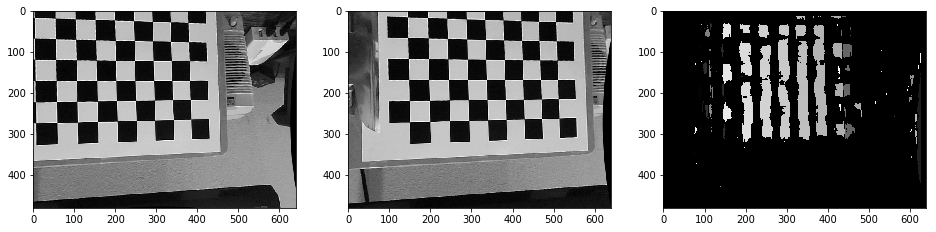

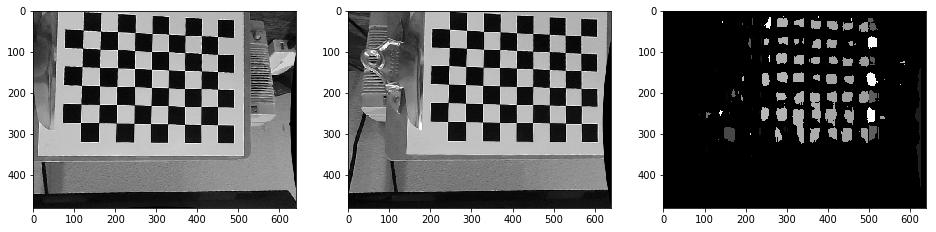

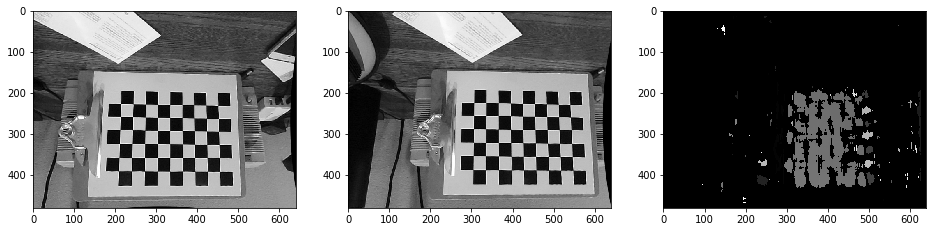

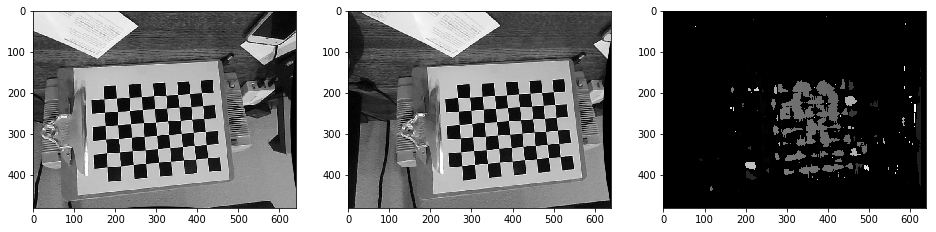

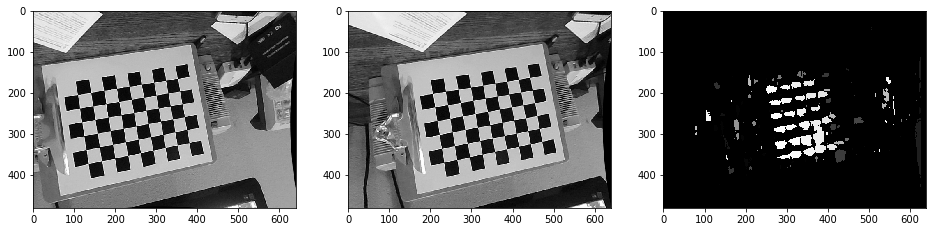

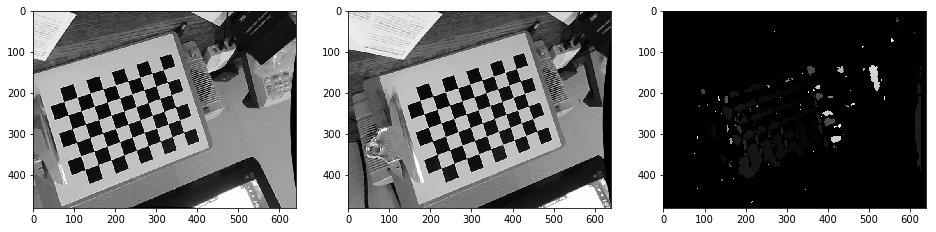

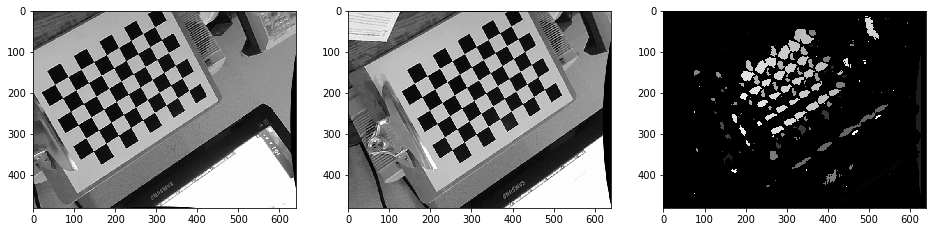

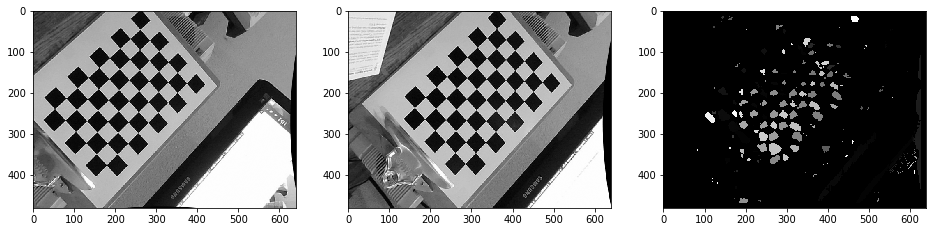

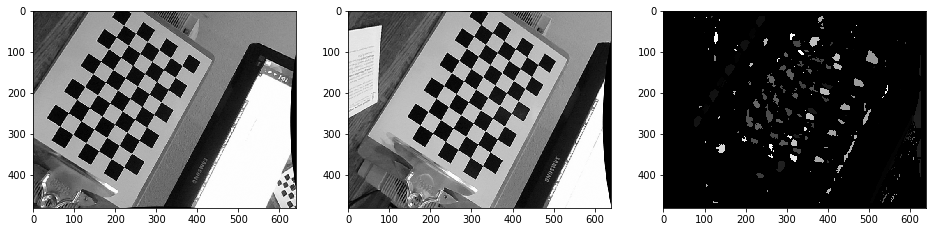

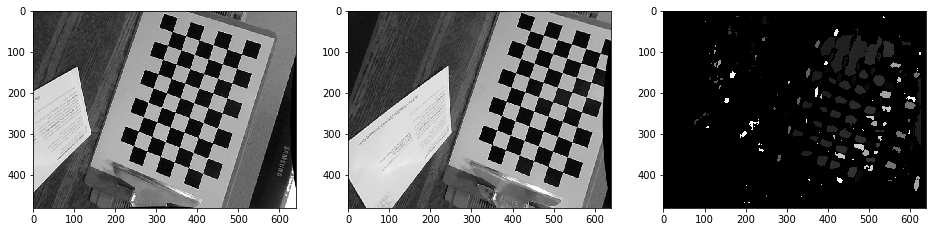

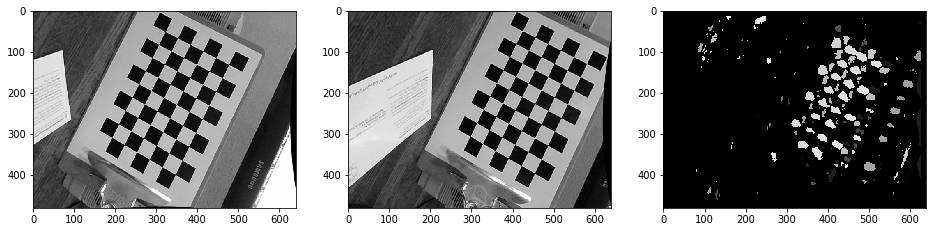

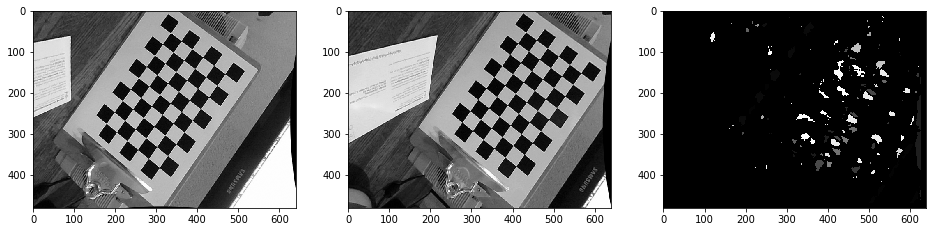

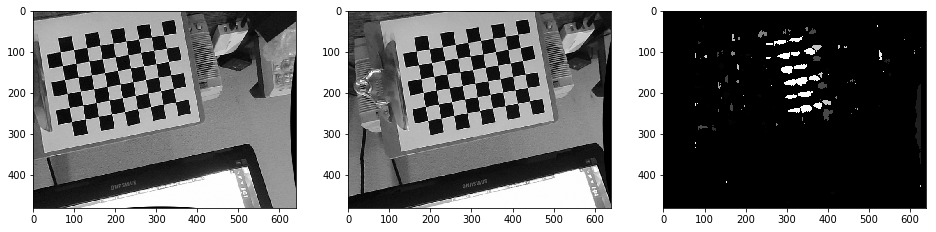

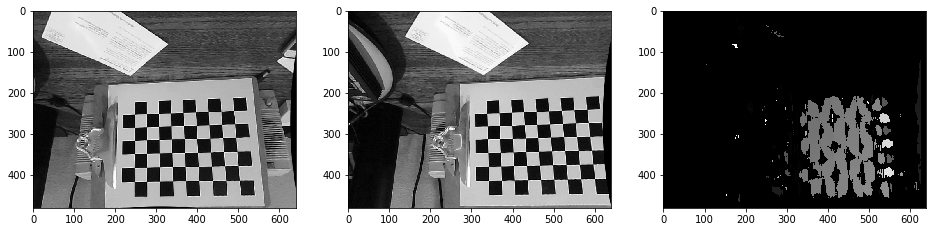

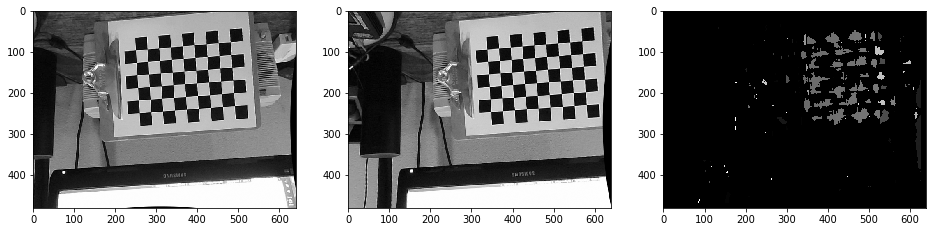

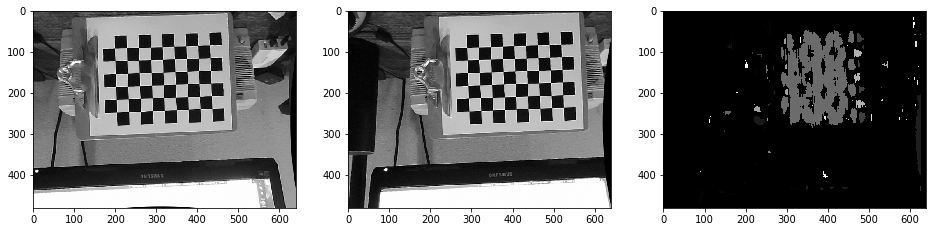

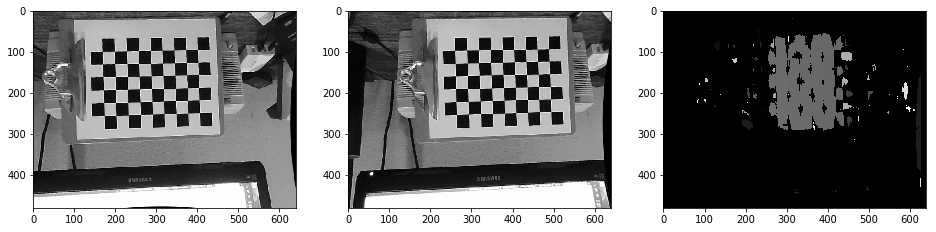

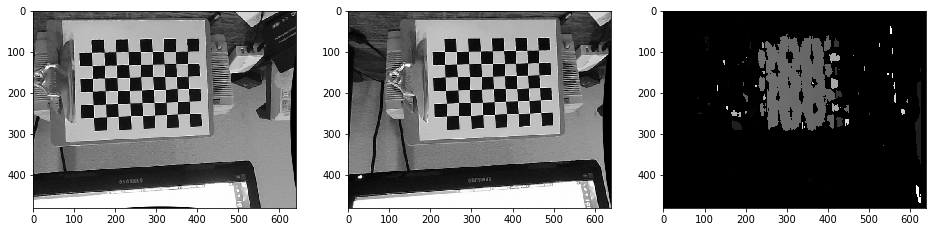

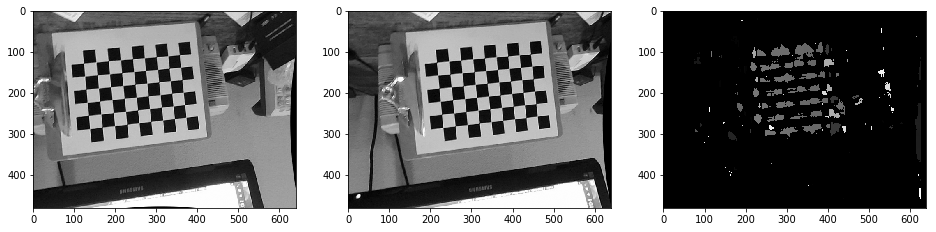

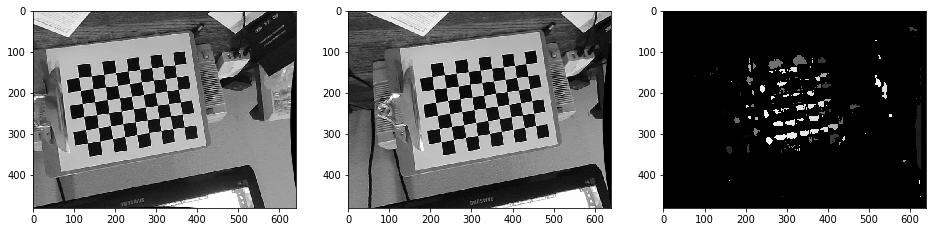

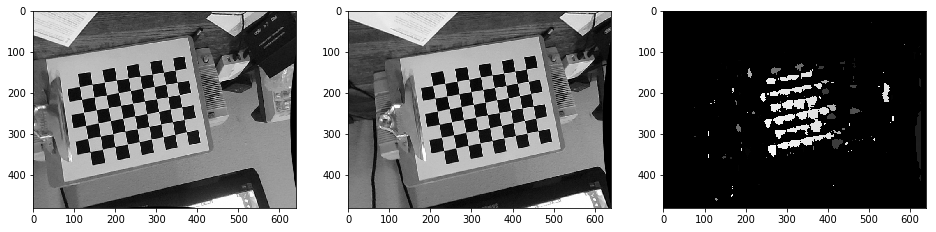

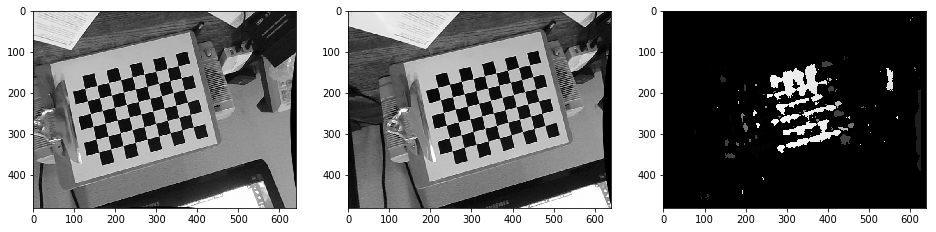

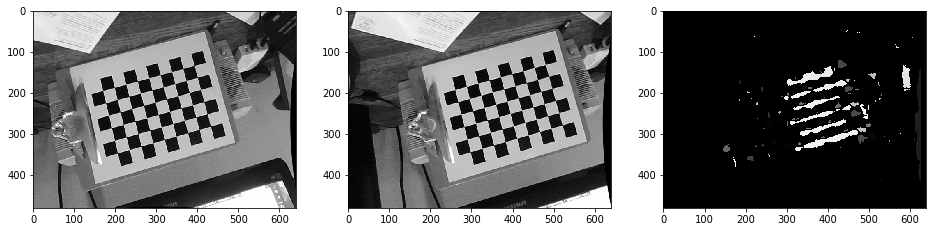

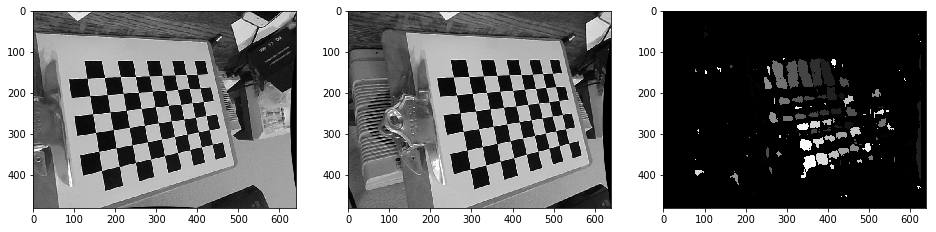

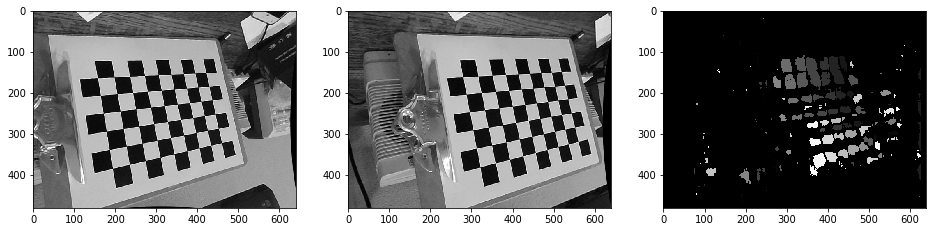

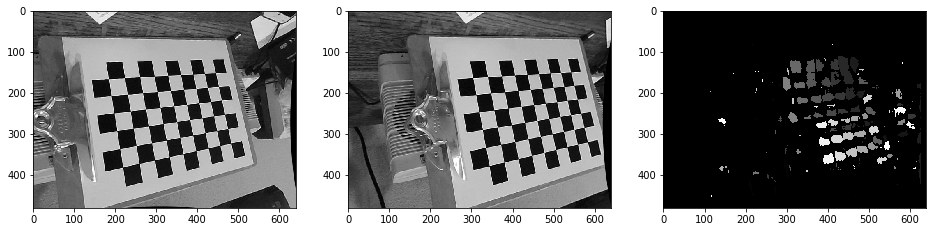

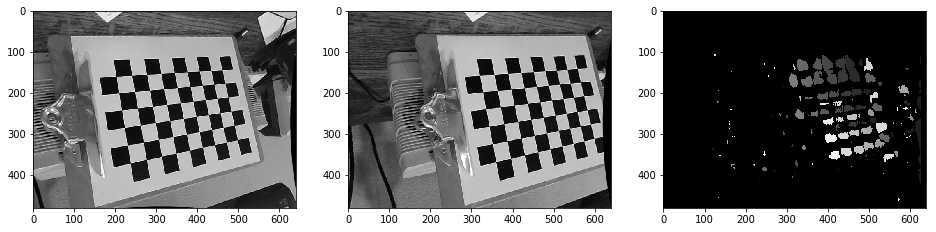

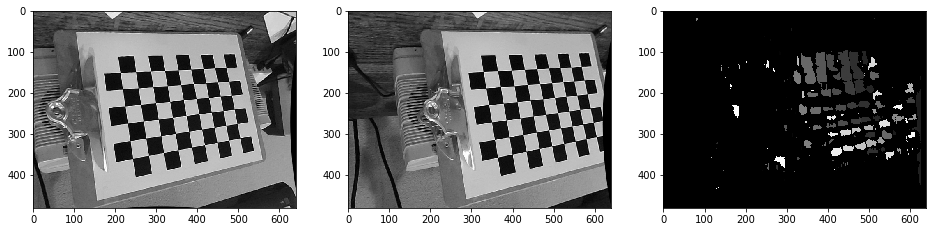

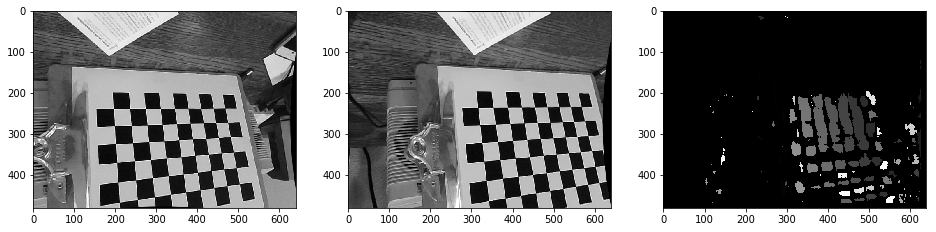

In [6]:
# stereo calibration of left and right images
chessboard_paths = sorted(glob.glob('chessboard_images/stereo/*'))
all_calibrations = dict()
for chessboard_path in sorted(chessboard_paths):
    camera_name = chessboard_path.split('/')[-1]
    for resolution_path in glob.glob(chessboard_path + "/*")[1:2]:
        resolution_name = resolution_path.split('/')[-1]
        print('processing',camera_name,resolution_name)
        camera = Camera()
        
        left_image_paths = sorted(glob.glob(resolution_path+'/*left.png'))
        right_image_paths = sorted(glob.glob(resolution_path+'/*right.png'))
        left_dist_coefs, left_camera_matrix, right_dist_coefs, right_camera_matrix, R, T, E, F = camera.stereo_calibrate(left_image_paths, right_image_paths)
        print('R:',R)
        print('T:',T)
        print('E:',E)
        print('F:',F)
        print('angle:', cv2.Rodrigues(R)[0][0]*180./math.pi)
        
        #all_calibrations[camera_name+'_left_'+resolution_name] = cal
        #all_calibrations[camera_name+'_right_'+resolution_name] = cal
        
        #cv2.stereoCalibrate()

#print(json.dumps(all_calibrations, indent=1))

In [117]:
#run them all
chessboard_paths = glob.glob('chessboard_images/mono/*')
all_calibrations = dict()
for chessboard_path in sorted(chessboard_paths):
    camera_name = chessboard_path.split('/')[-1]
    camera = Camera()
    print(chessboard_path)
    camera.calibrate(calibration_images = glob.glob(chessboard_path+'/*.png'))
    cal = dict()
    cal['dist_coefs'] = camera.dist_coefs.tolist()
    cal['camera_matrix'] = camera.camera_matrix.tolist()
    all_calibrations[camera_name] = cal
print(json.dumps(all_calibrations, indent=1))


chessboard_images/mono/elp1_left_1280_720
chessboard_images/mono/elp1_left_320_240
chessboard_images/mono/elp1_left_640_480
chessboard_images/mono/elp1_left_800_600
chessboard_images/mono/elp1_right_1280_720
chessboard_images/mono/elp1_right_320_240
chessboard_images/mono/elp1_right_640_480


KeyboardInterrupt: 

In [ ]:
# single calibration of left and right images
chessboard_paths = sorted(glob.glob('chessboard_images/stereo/*'))
all_calibrations = dict()
for chessboard_path in sorted(chessboard_paths):
    camera_name = chessboard_path.split('/')[-1]
    for resolution_path in glob.glob(chessboard_path + "/*"):
        resolution_name = resolution_path.split('/')[-1]
        print('processing',camera_name,resolution_name)
        camera = Camera()

        camera.calibrate(calibration_images = glob.glob(resolution_path+'/*left.png'))
        cal = dict()
        cal['dist_coefs'] = camera.dist_coefs.tolist()
        cal['camera_matrix'] = camera.camera_matrix.tolist()
        all_calibrations[camera_name+'_left_'+resolution_name] = cal

        camera.calibrate(calibration_images = glob.glob(resolution_path+'/*right.png'))
        cal = dict()
        cal['dist_coefs'] = camera.dist_coefs.tolist()
        cal['camera_matrix'] = camera.camera_matrix.tolist()
        all_calibrations[camera_name+'_right_'+resolution_name] = cal
        

print(json.dumps(all_calibrations, indent=1))

In [ ]:
camera = Camera()